In [88]:
import sys
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import Illustris
nexus_python_path = os.path.abspath("/Users/users/nastase/Applications/NEXUS_python/NEXUS_1.0/python/python_import/")
sys.path.append(nexus_python_path)
import illustris_python as il

# Import redshift to snapshot dict
shared_path = os.path.abspath("/Users/users/nastase/GitBub/Thesis/code/shared/")
sys.path.append(shared_path)
from utilities import get_redshift_dictionary

you extract the IDs associated to a particular environment at a snapshot.
then you look for those IDs in the other snapshot and check how many stayed in the same environment vs how many 
    moved to a different type of environment

In [89]:
def common_mass_fraction(df_joined, snapnum1, snapnum2, env1, env2 ):
    
    """
    snapnum1 should correspond to the snapshot of z1 and snapnum2 to the snapshot of z2
    
    
    IMPORTANT!!!! 
    
    if snapnum1 > snapnum2 -> z1 < z2 and the fraction is mass in env1 at z1 that originated in env2 at z2
    if snapnum1 < snapnum2 -> z1 > z2 and the fraction is mass in env1 at z1 that migrated to env2 at z2
    
    """
    
    df_env1_snap1 = df_joined[df_joined[f"particle_type_{snapnum1}"] == env1]
    denominator = df_env1_snap1.shape[0]
    
    df_env1_snap1_env2_snap2 = df_env1_snap1[df_env1_snap1[f"particle_type_{snapnum2}"] == env2]
    numerator = df_env1_snap1_env2_snap2.shape[0]
    
    f_i_j = (numerator/denominator)
    
    return f_i_j

In [95]:
def load_dfs(snapnums):
    
    dfs = []
    for snapnum in snapnums:
        if snapnum <100:
            snapnum = f"0{snapnum}"
        with open(f'/Users/users/nastase/PROJECT/DATA/nexus_outputs/particle_selecta/particle_types_dataframe_{snapnum}.pickle', 'rb') as handle:
            dfs.append(pickle.load(handle))
       
    return dfs

In [91]:
def join_dfs(base_df, dfs_to_join):
    df = base_df
    
    for df_to_join in dfs_to_join:
        df = df.join(df_to_join)
        
    return df

In [92]:
snapshot_list = get_redshift_dictionary()["snapshots"]

In [96]:
dfs = load_dfs(snapshot_list)

In [100]:
dfs[0].memory_usage()

Index                2917831904
particle_type_135     753571000
dtype: int64

make the dtype of index u32 and make the particle environment type a bit mask

In [103]:
dfs[0]['particle_type_135']

3454907     n
88038007    n
3454932     n
88043982    n
2455757     n
           ..
94196367    v
94196368    v
94196369    f
94196373    w
94196375    w
Name: particle_type_135, Length: 94196375, dtype: object

In [101]:
np.max(dfs[0].index.to_numpy())

94196375

In [97]:
joined_df_1 = join_dfs(dfs[0], dfs[1:10])
joined_df_2 = joind_dfs(dfs[10], dfs[11:20])
joined_df_3 = joind_dfs(dfs[20], dfs[21:])

MemoryError: Unable to allocate 9.12 GiB for an array with shape (13, 94196375) and data type object

In [15]:
joined_df.rename(columns={"particle_type":"particle_type_133"}, inplace=True)

In [ ]:
with open(f'/Users/users/nastase/PROJECT/DATA/nexus_outputs/particle_selecta/particle_ids_all.pickle', 'wb') as handle:
    pickle.dump(joined_df, handle, protocol=4)

i want to make plots of f_i_j (ie result of common_mass_fraction) vs the redshift of the snapshot; I want to do it for each env type (ie mass contributions to voids from other env, to filaments from other env...)

In [26]:
def proportions_for_snapshots(df, base_snapshot, snapshots, initial_particle_type):
    proportions_for_snapshot = {}

    for snapshot in snapshots:
        
        indexing_name = f'particle_type_{snapshot}'
        
        tmp = df[df[f"particle_type_{base_snapshot}"] == initial_particle_type][indexing_name]
        proportions = tmp.value_counts(normalize=True)
        proportions_for_snapshot[snapshot] = proportions
    
    return proportions_for_snapshot

In [27]:
def proportions_for_snapshots2(df, base_snapshot, snapshots, initial_particle_type):
    data = []

    for snapshot in snapshots:
        indexing_name = f'particle_type_{snapshot}'
        tmp = df[df[f"particle_type_{base_snapshot}"] == initial_particle_type][indexing_name]
        proportions = tmp.value_counts(normalize=True).reindex(['n', 'f', 'w', 'v'], fill_value=0)
        
        # Append a tuple with the snapshot index and the proportions for each type
        data.append(proportions)

    # Create a DataFrame from the list of Series objects
    return pd.DataFrame(data, index=snapshots, columns=['n', 'f', 'w', 'v'])

In [24]:
proportions = proportions_for_snapshots(joined_df, 110, [135, 133, 129, 110 ], 'n')

In [30]:
proportions2 = proportions_for_snapshots2(joined_df, 110, [135, 133, 129, 110 ], 'n')

In [51]:
proportions2.index.to_numpy()

array([135, 133, 129, 110])

In [49]:
get_redshift_dictionary()["redshifts"][get_redshift_dictionary()["snapshots"].index(proportions2.index[0])]

0.0

In [55]:
proportions2.index.map(lambda x: get_redshift_dictionary()["redshifts"][get_redshift_dictionary()["snapshots"].index(x)])

Index([0.0, 0.02, 0.07, 0.36], dtype='float64')

In [53]:


proportions2.index.to_numpy()[0]

135

In [37]:
type(proportions2['n'])

pandas.core.series.Series

In [56]:
redshifts = proportions2.index.map(
    lambda x: get_redshift_dictionary()["redshifts"][get_redshift_dictionary()["snapshots"].index(x)]
)
redshifts_values = redshifts.to_numpy()

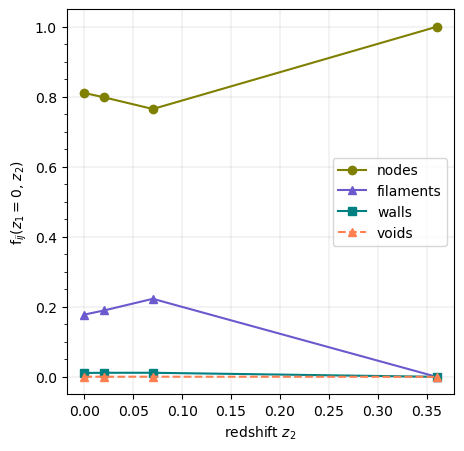

In [87]:
plt.figure(figsize=(5,5))
plt.plot(
    redshifts_values, 
    proportions2["n"].values, 
    'o-',color='#808000', label="nodes")
plt.plot(
    redshifts_values, 
    proportions2["f"].values,  
    '^-',color='#6A5ACD', label="filaments")
plt.plot(
    redshifts_values, 
    proportions2["w"].values,
    's-',color='#008080', label="walls")
plt.plot(
    redshifts_values, 
    proportions2["v"].values,
    '^--',color='#FF7F50', label="voids")
plt.grid(linewidth=0.2)
plt.yticks(np.linspace(0, 1, 20, endpoint=False), minor=True)
plt.xlabel("redshift $z_2$")
plt.ylabel("f$_{ij}$($z_1 = 0$, $z_2$)")
plt.legend()
plt.show()